In [1]:
import os
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import re
from pyvis.network import Network
import community as community_louvain
from src.filter_entity import filter_entity

## Load the data and model

In [2]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")
# Get all book files in the dataset folder
all_books = [b for b in os.scandir("dataset") if ".txt" in b.name]
all_books

[<DirEntry 'Book 3 - The Prisoner of Azkaban.txt'>,
 <DirEntry 'Book 7 - The Deathly Hallows.txt'>,
 <DirEntry 'Book 2 - The Chamber of Secrets.txt'>,
 <DirEntry 'Book 4 - The Goblet of Fire.txt'>,
 <DirEntry 'Book 6 - The Half Blood Prince.txt'>,
 <DirEntry "Book 1 - The Philosopher's Stone.txt">,
 <DirEntry 'Book 5 - The Order of the Phoenix.txt'>]

## Clean the data

In [3]:
# Load the characters from a CSV file into a Pandas DataFrame and set the first column as the index
df_character = pd.read_csv("characters.csv", index_col=0)

# Remove rows with missing values in the 'Character' column
df_character = df_character.dropna(subset=['Character'])

# Convert the 'Character' column to type string and remove any parentheses and their contents from the strings
df_character['Character'] = df_character['Character'].astype(str)
df_character['Character'] = df_character['Character'].apply(lambda x: re.sub("[\(].*?[\)]", " ", x))

# Split the 'Character' column into first name and last name columns
df_character["Character_firstname"] = df_character['Character'].apply(lambda x: x.split(' ', 1)[0])
df_character['Character_lastname'] = df_character['Character'].apply(lambda x: x.split(' ',1)[-1] if len(x.split(' ', 1)[-1].split()) <= 3 else '')

# Replace any empty strings in the DataFrame with NaN values
df_character.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Remove any rows with NaN values in the 'Character_lastname' column
df_character.dropna(subset=['Character_lastname'], inplace=True)

# df_character['Character']

In [4]:
pd.set_option('display.max_rows', None)
df_character.head()

,Alphabet Index,Character,Character_firstname,Character_lastname
1,A,Mrs. Abbott,Mrs.,Abbott
2,A,Abbott family,Abbott,family
3,A,Hannah Abbott,Hannah,Abbott
4,A,Abel Treetops,Abel,Treetops
5,A,Euan Abercrombie,Euan,Abercrombie


## Get named entity list per sentence

In [5]:
# Select a book from a list of books
book = all_books[0]
# Read in the text of the book
book_text = open(book).read()
# Set the maximum document length for spaCy's named entity recognition model
NER.max_length = 1700000
# Apply spaCy's named entity recognition model to the book text to identify named entities
book_doc = NER(book_text)
# Visualize the identified entities in the first 500 characters of the book using spaCy's built-in visualization tool
displacy.render(book_doc[0:500], style="ent", jupyter=True)

In [6]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)
sent_entity_df.head()

,sentence,entities
0,"(/, \n\n\n\n\n, OWL, POST, \n\n, Harry, Potter...","[OWL POST, Harry Potter]"
1,"(For, one, thing, ,, he, hated, the, summer, h...","[one, the summer holidays]"
2,"(For, another, ,, he, really, \n, wanted, to, ...",[night]
3,"(And, he, also, happened, to, \n, be, a, wizar...",[]
4,"(It, was, nearly, midnight, ,, and, he, was, l...","[nearly midnight, (A History of Magic, Bathilda]"


In [7]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, df_character))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
0,"(/, \n\n\n\n\n, OWL, POST, \n\n, Harry, Potter...","[OWL POST, Harry Potter]",[Harry Potter]
4,"(It, was, nearly, midnight, ,, and, he, was, l...","[nearly midnight, (A History of Magic, Bathilda]",[Bathilda]
7,"(Harry, pushed, his, round, glasses, up, the, ...","[Harry, Harry Potter, Azkaban - J.K. Rowling, ...","[Harry, Harry Potter]"
10,"(Indeed, ,, Wendelin, the, Weird, \n, enjoyed,...",[Wendelin the Weird],[Wendelin the Weird]
11,"(Harry, put, his, quill, between, his, teeth, ...",[Harry],[Harry]
13,"(The, Dursley, family, of, number, four, ,, Pr...","[Dursley, number four, Privet Drive, Harry]","[Dursley, Harry]"
14,"(Uncle, Vernon, ,, Aunt, Petunia, ,, and, thei...","[Uncle Vernon, Aunt Petunia, Dudley, Harry]","[Dudley, Harry]"
16,"(Harry, ’s, dead, parents, ,, who, had, been, ...",[Harry],[Harry]
17,"(For, years, ,, Aunt, Petunia, and, \n, Uncle,...","[years, Aunt Petunia, Uncle Vernon, Harry]",[Harry]
19,"(These, days, they, lived, in, terror, of, \n,...","[These days, Harry, Hogwarts School of Witchcr...",[Harry]


In [8]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered  

/var/folders/d6/4ww_t_md77b57vhv75x05wsw0000gn/T/ipykernel_38411/787768310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


,sentence,entities,character_entities
0,"(/, \n\n\n\n\n, OWL, POST, \n\n, Harry, Potter...","[OWL POST, Harry Potter]",[Harry]
4,"(It, was, nearly, midnight, ,, and, he, was, l...","[nearly midnight, (A History of Magic, Bathilda]",[Bathilda]
7,"(Harry, pushed, his, round, glasses, up, the, ...","[Harry, Harry Potter, Azkaban - J.K. Rowling, ...","[Harry, Harry]"
10,"(Indeed, ,, Wendelin, the, Weird, \n, enjoyed,...",[Wendelin the Weird],[Wendelin]
11,"(Harry, put, his, quill, between, his, teeth, ...",[Harry],[Harry]
...,...,...,...
8894,"(Ron, yelled, after, Harry, \n, as, Harry, bid...","[Ron, Harry \n, Harry, Hermione, Hedwig, Uncle...","[Ron, Harry, Hermione, Hedwig]"
8896,"(he, snarled, ,, staring, at, the, envelope, \...",[Harry],[Harry]
8901,"(Page, |, 486, Harry, Potter, and, the, Prison...","[Harry Potter, Azkaban - J.K. Rowling, Harry b...",[Harry]
8905,"(And, ,, grinning, broadly, at, the, look, of,...","[Uncle, Harry, Hedwig, a much better summer]","[Harry, Hedwig]"


## Create Relationship

In [9]:
window_size = 5
relationships = []

# Iterate through the indices of the filtered entity dataframe
for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])  # Set the end index for the window
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])  # Flatten the character entities in the window

    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    # Add a relationship to the list for each pair of unique characters within the window
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})


In [10]:
relationship_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationship_df.head()
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head(20)

,source,target
0,Bathilda,Harry
1,Bathilda,Harry
2,Bathilda,Harry
3,Bathilda,Harry
4,Harry,Wendelin
5,Harry,Wendelin
6,Harry,Wendelin
7,Harry,Wendelin
8,Harry,Wendelin
9,Harry,Wendelin


In [11]:
# Add a new column with value 1 to the DataFrame
relationship_df["value"] = 1

# Group the DataFrame by source and target, and sum the values
relationship_df2 = relationship_df.groupby(["source", "target"], sort=False, as_index=False)["value"].sum()

# Remove rows where the target is 'two', 'three', 'second', 'Welcome', 'Miss', or 'Uncle'
targets_to_remove = ['two', 'three', 'second', 'Welcome', 'Miss', 'Uncle']
relationship_df2 = relationship_df2[~relationship_df2["target"].isin(targets_to_remove)]


## Plot a graph with `networkx`

In [12]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df2, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

In [13]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [14]:
# net = Network(notebook=True, height="700px", width="1000px", bgcolor="#222222", font_color="white")
# node_degree = dict(G.degree)
# #Setting up node size attribute
# nx.set_node_attributes(G, node_degree, 'size')

# net.from_nx(G)
# net.repulsion()
# net.show('Harry.html')

## The most important characters

In [15]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Bathilda': 0.010309278350515464,
 'Harry': 0.8969072164948454,
 'Wendelin': 0.020618556701030927,
 'Dursley': 0.020618556701030927,
 'Dudley': 0.041237113402061855,
 'Snape': 0.28865979381443296,
 'Ron': 0.4948453608247423,
 'Vernon': 0.07216494845360824,
 'Hogwarts': 0.13402061855670103,
 'Hermione': 0.28865979381443296,
 'Muggle': 0.09278350515463918,
 'Hedwig': 0.1134020618556701,
 'Lily': 0.061855670103092786,
 'James': 0.15463917525773196,
 'Errol': 0.05154639175257732,
 'Weasley': 0.29896907216494845,
 'Arthur': 0.061855670103092786,
 'Bill': 0.041237113402061855,
 'Ginny': 0.09278350515463918,
 'Percy': 0.20618556701030927,
 'Fleetwood': 0.020618556701030927,
 'Hagrid': 0.20618556701030927,
 'Petunia': 0.041237113402061855,
 'Ripper': 0.030927835051546393,
 'Ministry': 0.061855670103092786,
 'Stan': 0.07216494845360824,
 'Neville': 0.2268041237113402,
 'Ernie': 0.041237113402061855,
 'Sirius': 0.1958762886597938,
 'Cornelius': 0.10309278350515463,
 'Fudge': 0.25773195876288657

<AxesSubplot: >

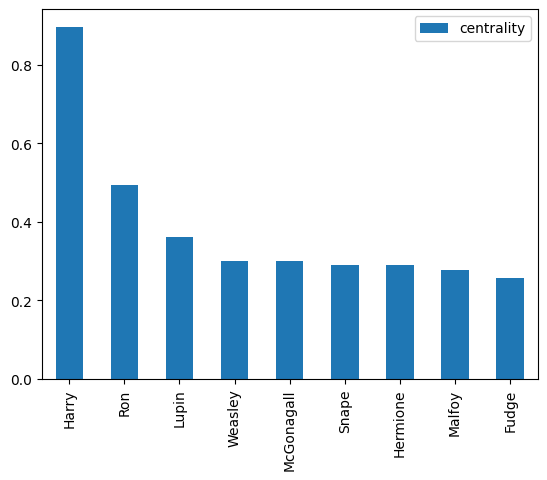

In [16]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot: >

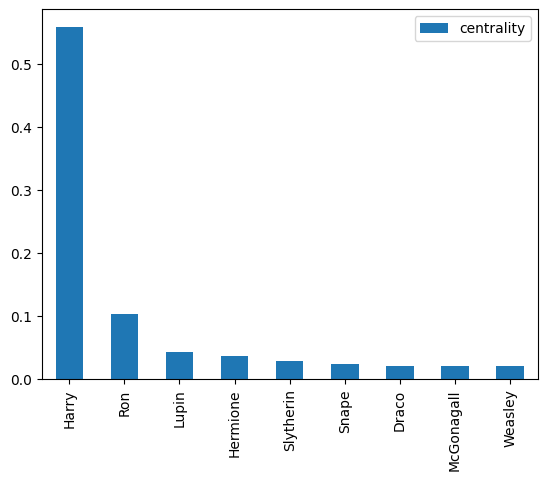

In [17]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot: >

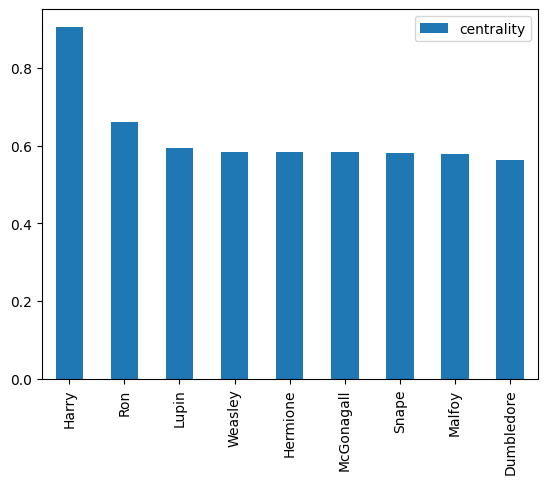

In [18]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [19]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Community detection

In [20]:

communities = community_louvain.best_partition(G)
communities

{'Bathilda': 0,
 'Harry': 0,
 'Wendelin': 0,
 'Dursley': 0,
 'Dudley': 0,
 'Snape': 3,
 'Ron': 1,
 'Vernon': 0,
 'Hogwarts': 4,
 'Hermione': 4,
 'Muggle': 5,
 'Hedwig': 5,
 'Lily': 3,
 'James': 3,
 'Errol': 5,
 'Weasley': 5,
 'Arthur': 5,
 'Bill': 1,
 'Ginny': 1,
 'Percy': 4,
 'Fleetwood': 0,
 'Hagrid': 4,
 'Petunia': 0,
 'Ripper': 0,
 'Ministry': 5,
 'Stan': 5,
 'Neville': 5,
 'Ernie': 5,
 'Sirius': 4,
 'Cornelius': 5,
 'Fudge': 3,
 'Tom': 3,
 'Potter': 3,
 'Florean': 0,
 'Cassandra': 0,
 'Seamus': 1,
 'Dean': 1,
 'Madam': 3,
 'Scabbers': 3,
 'Crookshanks': 4,
 'George': 2,
 'Fred': 2,
 'Molly': 5,
 'Black': 3,
 'Albus': 5,
 'Dumbledore': 3,
 'Penelope': 4,
 'Hermes': 5,
 'Lupin': 3,
 'McGonagall': 3,
 'Draco': 4,
 'Vincent': 4,
 'Malfoy': 2,
 'Goyle': 4,
 'Crabbe': 1,
 'Great': 1,
 'Longbottom': 3,
 'Granger': 3,
 'Poppy': 3,
 'Slytherin': 2,
 'Rubeus': 4,
 'Pansy': 4,
 'Parvati': 1,
 'Lavender': 1,
 'Buckbeak': 4,
 'Fang': 1,
 'Trevor': 5,
 'Peeves': 3,
 'Alicia': 2,
 'Angelina': 2,

In [ ]:
nx.set_node_attributes(G, communities, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.repulsion()
com_net.show("Harry_communities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
